In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from flask import Flask, jsonify
from flask_sqlalchemy import SQLAlchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

Text(0, 0.5, 'inches')

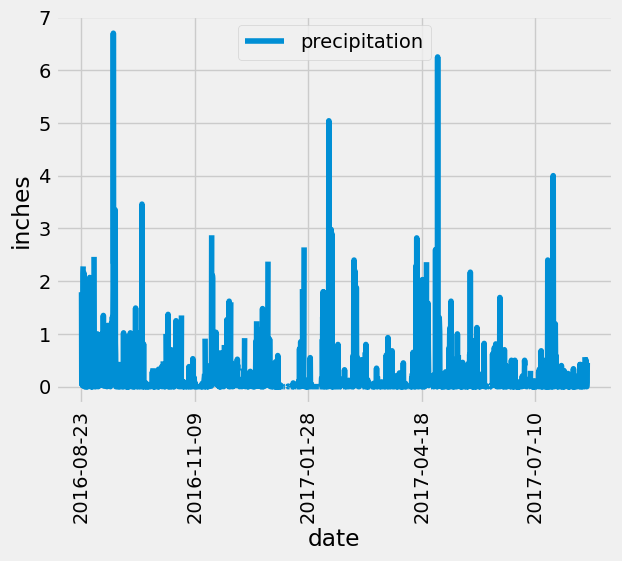

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime("2017-08-23", "%Y-%m-%d").date()
date_range = recent_date - dt.timedelta(days=365)

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=("date", 'precipitation'))

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x="date", y='precipitation', rot=90)
plt.xlabel("date")
plt.ylabel("inches")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
most_active_station = active_stations[0][0]

# Query to get temperature data for the most active station
temp_results = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).all()

# Convert the results to a DataFrame
temp_df = pd.DataFrame(temp_results, columns=['tobs'])

# Calculate the lowest, highest, and average temperature
lowest_temp = temp_df['tobs'].min()
highest_temp = temp_df['tobs'].max()
average_temp = temp_df['tobs'].mean()

# Print the results
print(f'Lowest Temperature: {lowest_temp}')
print(f'Highest Temperature: {highest_temp}')
print(f'Average Temperature: {average_temp}')


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


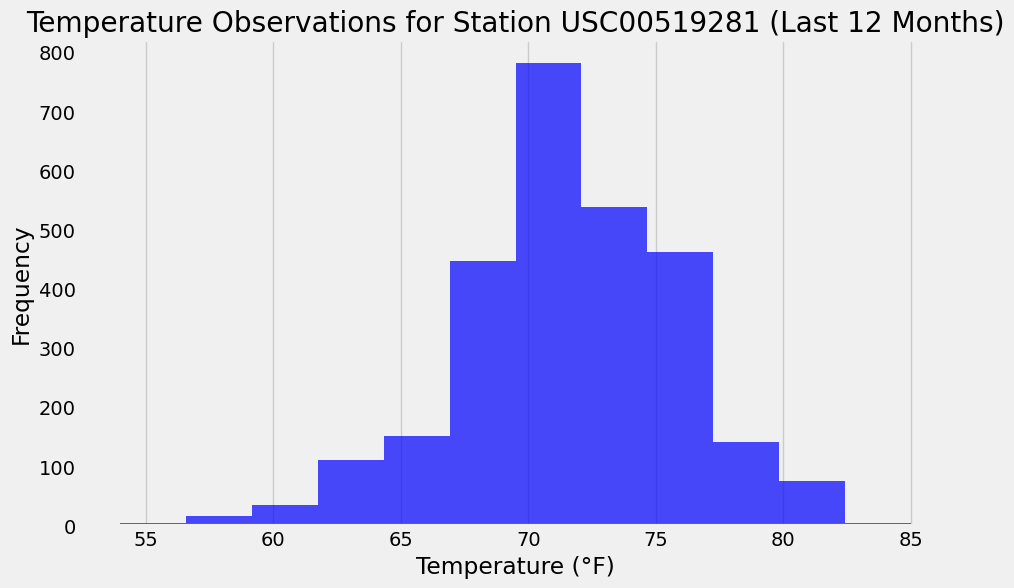

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = dt.datetime.strptime("2017-08-23", "%Y-%m-%d").date()
prev_year = last_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temp_last_year = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= prev_year
).all()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_df['tobs'], bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [18]:
app = Flask(__name__)

# SQLite database configuration
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///Resources/hawaii.sqlite'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
@app.route('/')
def index():
    routes = {
        'Precipitation': '/api/v1.0/precipitation',
        'Stations': '/api/v1.0/stations',
        'TOBS': '/api/v1.0/tobs',
        'Start': '/api/v1.0/start/<start>',
        'Start/End': '/api/v1.0/start/<start>/end/<end>'
    }
    return jsonify(routes)

# Static Routes

@app.route('/api/v1.0/precipitation')
def precipitation():
    # Get the most recent date
    most_recent_date = session.query(func.max(Measurement.date)).first()[0]
    recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d").date()
    prev_year = recent_date - dt.timedelta(days=365)

    # Query for precipitation data
    results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
    precipitation_data = {date: prcp for date, prcp in results}
    return jsonify(precipitation_data)

@app.route('/api/v1.0/stations')
def stations():
    results = session.query(Station.station, Station.name).all()
    stations_data = [{station: name} for station, name in results]
    return jsonify(stations_data)

@app.route('/api/v1.0/tobs')
def tobs():
    most_active_station = 'USC00519281'  # Based on your previous example
    one_year_ago = dt.datetime.now() - dt.timedelta(days=365)
    
    results = session.query(Measurement.tobs).filter(
        Measurement.station == most_active_station,
        Measurement.date >= one_year_ago
    ).all()
    
    tobs_data = [tob[0] for tob in results]
    return jsonify(tobs_data)

# Dynamic Routes

@app.route('/api/v1.0/start/<start>')
def start(start):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d')
    results = session.query(Measurement.tobs).filter(Measurement.date >= start_date).all()
    
    temps = [tob[0] for tob in results]
    
    return jsonify({
        'min': min(temps),
        'max': max(temps),
        'avg': sum(temps) / len(temps) if temps else None
    })

@app.route('/api/v1.0/start/<start>/end/<end>')
def start_end(start, end):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d')
    
    results = session.query(Measurement.tobs).filter(
        Measurement.date >= start_date,
        Measurement.date <= end_date
    ).all()
    
    temps = [tob[0] for tob in results]
    
    return jsonify({
        'min': min(temps),
        'max': max(temps),
        'avg': sum(temps) / len(temps) if temps else None
    })


# Close session

In [17]:
# Close Session
session.close()